In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.ticker as ticker
import calendar

/home/msharath/anaconda/lib/python2.7/site-packages/matplotlib-1.5.0+439.g05cf385-py2.7-linux-i686.egg/matplotlib/__init__.py:877: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
df = pd.read_pickle('out/21/donations.pkl')
events = pd.read_pickle('out/41/events.pkl')

In [3]:
df.columns

Index([u'activity_date', u'city', u'fund', u'batch_num', u'amount_initial',
       u'amount_cleanup', u'zipcode', u'longitude', u'sales', u'county',
       u'charitable', u'amount', u'state', u'donor_id', u'timezone',
       u'latitude', u'appeal', u'activity_year', u'activity_month',
       u'activity_dow', u'activity_ym', u'activity_yq', u'activity_ymd',
       u'county_norm', u'census_region_name', u'state_name', u'county_id',
       u'is_service', u'channel', u'campaign_location_id',
       u'is_location_center', u'campaign_month_id', u'is_month_center'],
      dtype='object')

In [4]:
df = df[['donor_id','activity_year', 'amount', 'is_service','channel', 'city','county','state','activity_date','activity_ym','activity_month','appeal','campaign_location_id','campaign_month_id']]

## Nomenclature:
    1. Donation - is a charitable contribution
    2. Contribution - is not a charitable contribution

In [5]:
def get_data(rows):
    '''
    input: rows from dataframe for a specific donor
    output: money donated and contributed over the years
    '''
    return rows\
    .groupby(['activity_year', 'is_service'])\
    .agg({'amount': sum, 'activity_date': 'count'}).reset_index()

In [6]:
df[(df.donor_id=='_1D50SWTKX') & (df.activity_year == 2014)].reset_index()

,index,donor_id,activity_year,amount,is_service,channel,city,county,state,activity_date,activity_ym,activity_month,appeal,campaign_location_id,campaign_month_id
0,131797,_1D50SWTKX,2014,3500,False,Other,Kenmore,King,WA,2014-06-20,201406,6,Funds_SVGives,NaN,NaN
1,131807,_1D50SWTKX,2014,50,False,Funds_Givingcampaign,Kenmore,King,WA,2014-08-13,201408,8,Funds_Givingcampaign,NaN,NaN
2,131816,_1D50SWTKX,2014,5000,False,Matching,Kenmore,King,WA,2014-02-28,201402,2,Funds_Matching,NaN,NaN
3,131829,_1D50SWTKX,2014,10,False,Other,Kenmore,King,WA,2014-06-20,201406,6,Funds_SVGives,NaN,NaN
4,131832,_1D50SWTKX,2014,50,False,Matching,Kenmore,King,WA,2014-12-08,201412,12,Funds_Matching,NaN,NaN
5,131833,_1D50SWTKX,2014,425,False,Volunteer,Kenmore,King,WA,2014-09-02,201409,9,Funds_Volunteer_Hours,NaN,NaN
6,131838,_1D50SWTKX,2014,3510,False,Other,Kenmore,King,WA,2014-09-02,201409,9,Funds_SVGives,NaN,NaN


In [7]:
get_data(df[(df.donor_id=='_1D50SWTKX')])

,activity_year,is_service,amount,activity_date
0,2004,False,500,1
1,2005,False,3257,8
2,2006,False,4205,12
3,2007,False,3999,15
4,2008,False,3320,17
5,2009,False,11944,9
6,2009,True,110,2
7,2010,False,2721,7
8,2011,False,3380,10
9,2012,False,2880,8


In [8]:
donor_data = df\
.groupby('donor_id')\
.apply(get_data)\
.rename(columns={'activity_date': 'num_activities_in_year'})

donor_data.index = donor_data.index.droplevel(1)
donor_data = donor_data.reset_index()

In [9]:
year_of_donation = donor_data[(donor_data.is_service==False)]\
.groupby('donor_id')['activity_year']\
.rank(method='min')

year_of_donation.name = 'year_of_donation'

year_of_contribution = donor_data[(donor_data.is_service==True)]\
.groupby('donor_id')['activity_year']\
.rank(method='min')

year_of_contribution.name = 'year_of_contribution'

In [10]:
donor_data = pd.concat((donor_data, year_of_donation), axis=1)
donor_data = pd.concat((donor_data, year_of_contribution), axis=1)

In [11]:
# First forward fill the data and then replace with zeros if there are still any nulls lying around
donor_data.year_of_contribution = donor_data.year_of_contribution.fillna(method='ffill')
donor_data.year_of_donation = donor_data.year_of_donation.fillna(method='ffill')

donor_data.year_of_contribution = donor_data.year_of_contribution.fillna(0)
donor_data.year_of_donation = donor_data.year_of_donation.fillna(0)

In [12]:
def get_repeat_years(years):
    '''
    input: years of activity for donor
    output: list of boolean representing if the year was a repeat year donation
    '''
    #years = rows.activity_year.unique()
    repeat_years = [y for y in years.values if y-1 in years.values]
    return years.isin(repeat_years)

In [13]:
donor_data['is_repeat_year'] = donor_data[(donor_data.is_service==False)]\
    .groupby('donor_id')['activity_year']\
    .apply(get_repeat_years)

In [14]:
donor_data[(donor_data.donor_id=='-0Q51CZR4Q')]

,donor_id,activity_year,is_service,amount,num_activities_in_year,year_of_donation,year_of_contribution,is_repeat_year
46,-0Q51CZR4Q,2002,True,20,1,2,1,NaN
47,-0Q51CZR4Q,2003,False,20,1,1,1,False
48,-0Q51CZR4Q,2004,True,48,1,1,2,NaN
49,-0Q51CZR4Q,2005,False,60,1,2,2,False
50,-0Q51CZR4Q,2005,True,180,2,2,3,NaN
51,-0Q51CZR4Q,2006,False,2950,8,3,3,True
52,-0Q51CZR4Q,2006,True,446,3,3,4,NaN
53,-0Q51CZR4Q,2007,False,2600,4,4,4,True
54,-0Q51CZR4Q,2007,True,225,2,4,5,NaN
55,-0Q51CZR4Q,2008,False,1073,2,5,5,True


In [15]:
!mkdir -p out/42
donor_data.to_pickle('out/42/donors.pkl')

# Plots! Plots! Plots!
#### Let us use only 2014 data and before since the 2015 data is incomplete

In [16]:
import locale

In [17]:
df = df[(df.activity_year!=2015)]
donations = df[(df.is_service==False) & (df.activity_year!=2015)]
donor_data = donor_data[donor_data.activity_year!=2015]
events = events[events.activity_year!=2015]

In [18]:
color1 = '#67a9cf'
color2 = '#fc8d59'
colors = [color1, color2]

_ = locale.setlocale(locale.LC_ALL, '')
thousands_sep = lambda x: locale.format("%.2f", x, grouping=True)

### Do people tend to give more money along the years?

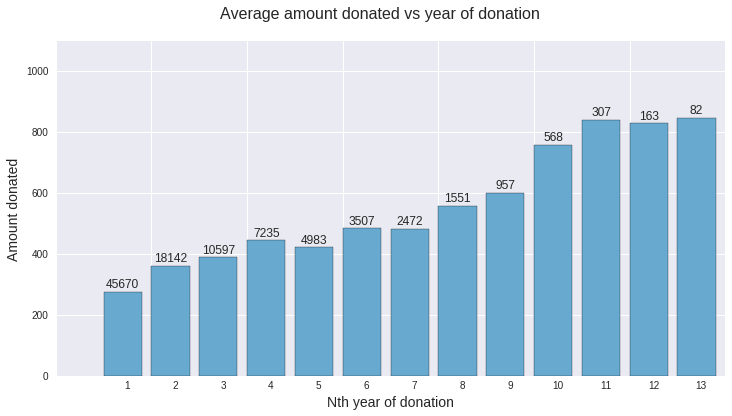

In [19]:
data = donor_data\
.groupby('year_of_donation')\
.agg({'amount': ['mean'], 'donor_id': 'size'})\
.iloc[1:-1]

data.columns = data.columns.droplevel(0)

fig, ax = plt.subplots(figsize=(12,6))
plt.bar(data.index, data['mean'],color=color1)
plt.xlabel('Nth year of donation', fontsize=14)
plt.ylabel('Amount donated', fontsize=14)
ax.xaxis.set_major_formatter(ticker.NullFormatter())

ax.set_ylim([0,1100])

# Put numbers on top of the bars
rects = ax.patches
labels = data['size'].values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

ax.xaxis.set_minor_locator(ticker.FixedLocator(data.index.values+0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(data.index.values.astype('int')))
_ = fig.suptitle('Average amount donated vs year of donation', fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/Amount_Donated_In_Nth_Year.png')

### What proportion of donors are new donors vs donors that have already been donating

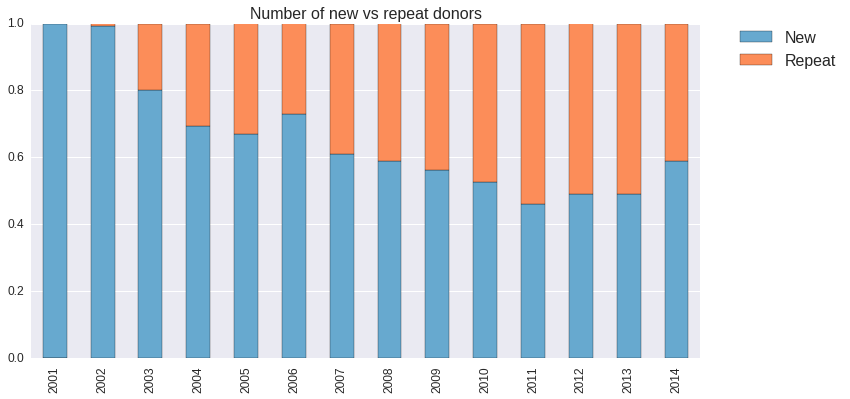

In [20]:
data = donor_data[(donor_data.is_service==False)].groupby(['activity_year', 'is_repeat_year']).donor_id.nunique().unstack().fillna(0)

data = pd.DataFrame(data.values, columns=['New','Repeat'], index=np.sort(data.index.unique()))
data = data.apply(lambda x: x/x.sum(), axis=1)

plot = data.plot(kind='bar',
              stacked=True,
              fontsize=12,
              color=colors,
              figsize=(12,6))
#plot.legend(prop={'size':16})
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':16}, borderaxespad=0.)
plot.set_title('Number of new vs repeat donors',fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/NumberofNewVsRepeatDonors.png', bbox_extra_artists=(legend,), bbox_inches='tight')

### What proportion of the total donation amount is coming in from new vs repeat donors

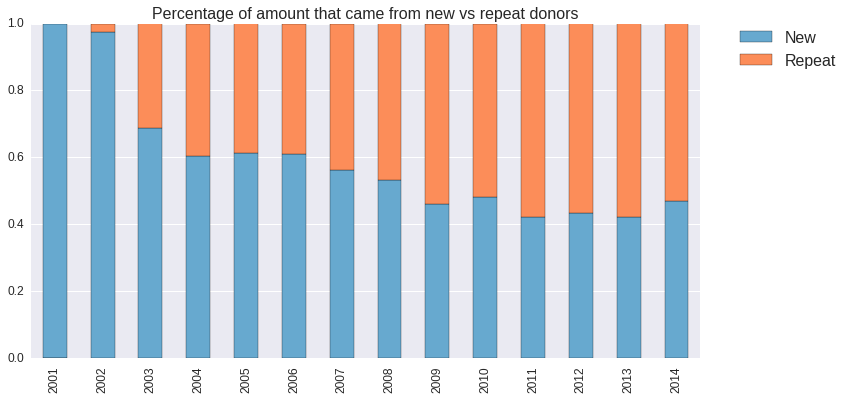

In [21]:
data = donor_data[(donor_data.is_service==False)].groupby(['activity_year', 'is_repeat_year']).amount.sum().unstack().fillna(0)
data = pd.DataFrame(data.values, columns=['New','Repeat'], index=np.sort(data.index.unique()))
data = data.apply(lambda x: x/x.sum(), axis=1)

plot = data.plot(kind='bar',
              stacked=True,
              color=colors,
              fontsize=12,
              figsize=(12,6))
#plot.legend(prop={'size':16})
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc=0, prop={'size':16}, borderaxespad=0.)
plot.set_title('Percentage of amount that came from new vs repeat donors',fontsize=16)
plt.savefig('/home/msharath/repos/SEF/viz/AmountFromNewVsRepeatDonors.png', bbox_extra_artists=(legend,), bbox_inches='tight')

In [22]:
### What proportion of money is coming in through various marketing channels

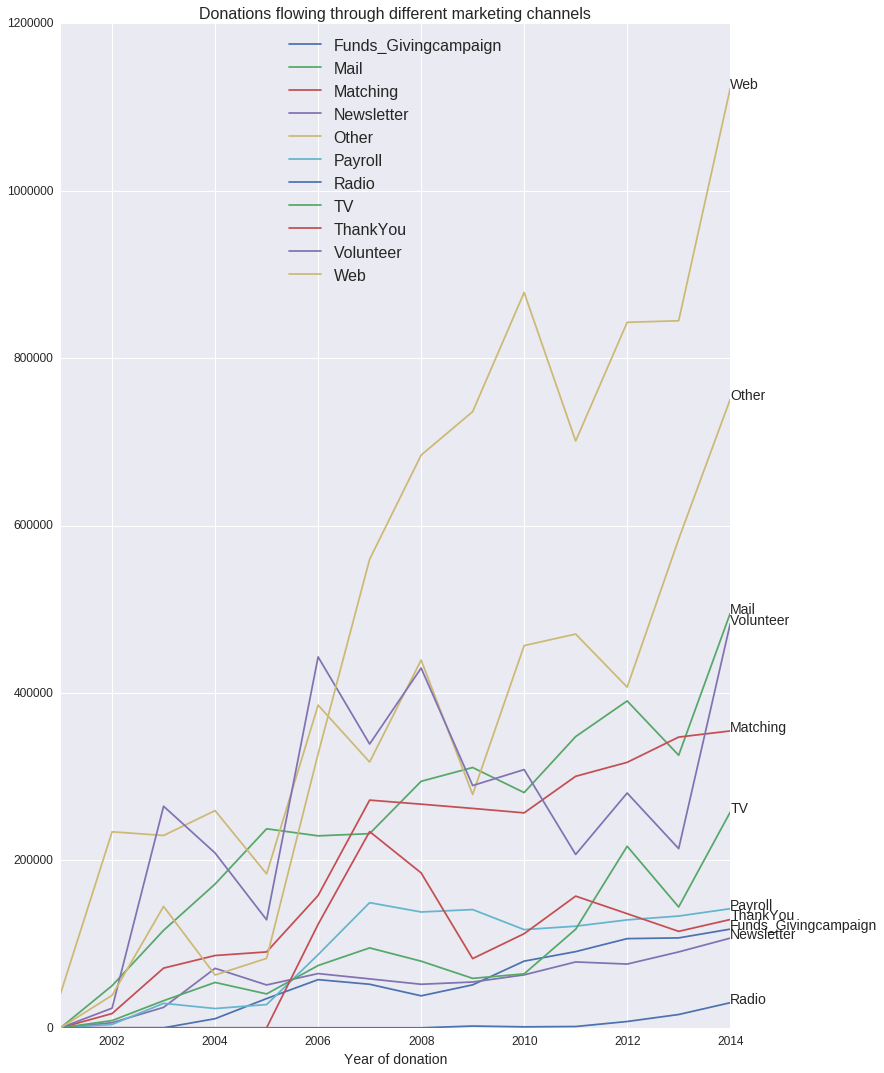

In [23]:
x = donations\
    .groupby(['activity_year', 'channel']).amount.sum().to_frame().unstack().fillna(0)
x.columns = x.columns.droplevel(0)

plot = x.plot(kind='line',
              fontsize=12,
              figsize=(12,18))

#plt.legend().set_visible(False)
plt.legend(prop={'size':16}, loc='upper center')
plot.set_title('Donations flowing through different marketing channels',fontsize=16)
plt.xlabel('Year of donation', fontsize=14)


for idx, x_value in enumerate(x[x.index==2014].values[0]):
    plt.text(2014, x_value, x.columns[idx], fontsize=14)
plt.savefig('/home/msharath/repos/SEF/viz/DonationsFromDifferentMarketingChannels.png')

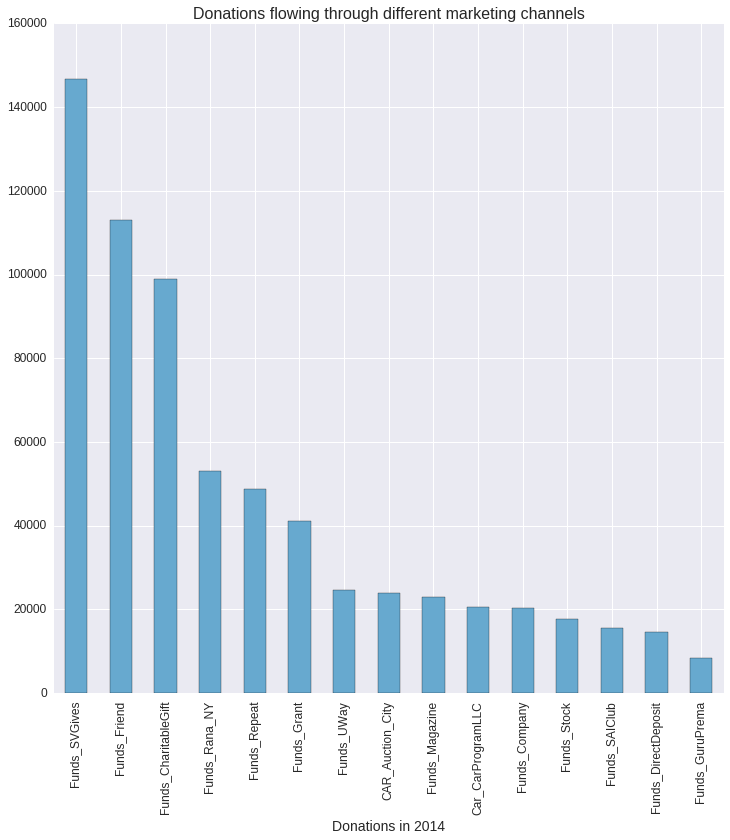

In [24]:
x = donations[(donations.activity_year==2014) & (donations.channel=='Other')]\
    .groupby(['appeal']).amount.sum().to_frame().unstack().fillna(0).sort_values(ascending=False)[:15].to_frame()
x.index = x.index.droplevel(0)
x.columns = ['Total Donation Amount']

plot = x.plot(kind='bar',
              fontsize=12,
              color=color1,
              figsize=(12,12))

plt.legend().set_visible(False)
plot.set_title('Donations flowing through different marketing channels',fontsize=16)
plt.xlabel('Donations in 2014', fontsize=14)

plt.savefig('/home/msharath/repos/SEF/viz/OtherIn2014.png')

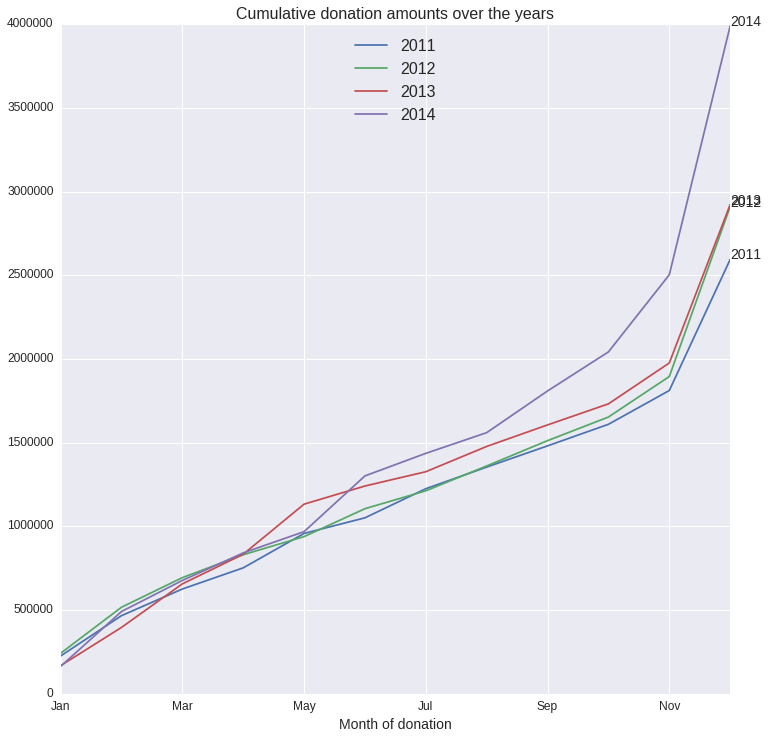

In [25]:
cumulative_years = np.cumsum(
    donations[(donations.activity_year > 2010)]\
        .groupby(['activity_year', 'activity_month'])['amount', ]\
        .sum()\
        .unstack()\
        .fillna(0)
    , axis=1, dtype='int64').T

cumulative_years.index = cumulative_years.index.droplevel(0)
cumulative_years.index = calendar.month_abbr[1:]

plot = cumulative_years.plot(kind='line',
              fontsize=12,
              figsize=(12,12))

plt.xlabel('Month of donation', fontsize=14)
plot.set_title('Cumulative donation amounts over the years',fontsize=16)
plt.legend(prop={'size':16}, loc='upper center')

vals = cumulative_years.ffill(axis=0)[-1:].columns.values
heights = cumulative_years.ffill(axis=0)[-1:].values[0]


[plt.text(11, height, val, fontsize=14) for (val, height) in zip(vals, heights)]

plt.savefig('/home/msharath/repos/SEF/viz/CumulativeDonationsOverTheYears.png')

/home/msharath/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


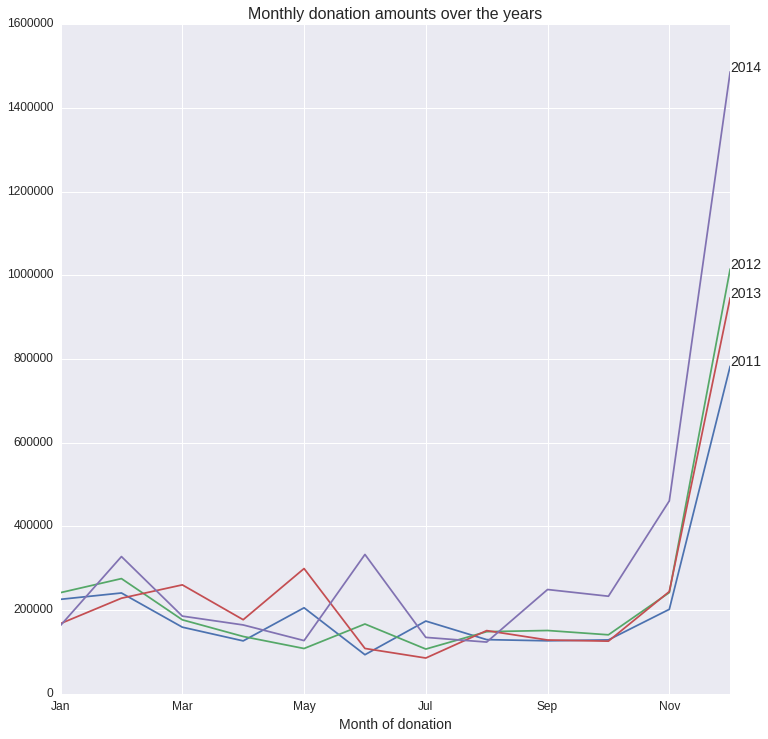

In [26]:
ymdata = donations[(df.activity_year > 2010)].groupby(['activity_year', 'activity_month'])['amount', ]\
        .sum()\
        .unstack()\
        .fillna(0).T

ymdata.index = ymdata.index.droplevel(0)
ymdata.index = calendar.month_abbr[1:13]

plot = ymdata.plot(kind='line',
              fontsize=12,
              figsize=(12,12))

plt.xlabel('Month of donation', fontsize=14)

plot.set_title('Monthly donation amounts over the years',fontsize=16)

plt.legend().set_visible(False)

vals = ymdata.ffill(axis=0)[-1:].columns.values
heights = ymdata.ffill(axis=0)[-1:].values[0]

[plt.text(11, height, val, fontsize=14) for (val, height) in zip(vals, heights)]

plt.savefig('/home/msharath/repos/SEF/viz/DonationsOverTheYears.png')

### How do fund-raisers impact donation dollars?

In [42]:
from itertools import cycle

def plot_event_donation_activity(state, years):

    ymdata = np.cumsum(
        donations[(donations.state==state)].groupby(['activity_year','activity_month'])['amount', ]\
        .sum()\
        .unstack()\
        .fillna(0),
        axis=1, dtype='int64')
        
    state_events = events[(events.state==state)][['event_name', 'amount', 'activity_month', 'activity_year']]\
    .sort_values(by=['activity_year', 'activity_month']).reset_index(drop=True)
    
    ymdata.columns = ymdata.columns.droplevel(0)
    
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Donation amount')

    vals = ymdata.index.values
    heights = ymdata.ffill(axis=1)[-1:].values[0]
    #[plt.text(12, height, val, fontsize=14) for (val, height) in zip(vals, heights)]

    ax2 = ax1.twinx()
    ax2.set_ylabel('Event contributions')

    colors = cycle(["r", "b", "g"])
    for year in years:
        color = next(colors)
        s1 = ymdata[ymdata.index==year].values[0]
        t = range(1,13)
        ax1.plot(t, s1, color=color, label=year)

        evs = state_events[state_events.activity_year==year]
        for ev in evs.iterrows():
            bar = ax2.bar(ev[1].activity_month, ev[1].amount, width=-0.4, alpha=0.2, color=color)
            label = ev[1].event_name
            
            # Put event_name on top of the bars
            rect = bar.patches[0]
            height = rect.get_height()
            ax2.text(rect.get_x() + rect.get_width()/2,
                     height + 5,
                     label,
                     ha='center',
                     va='bottom',
                     rotation='vertical',
                     fontsize=12)
    ax1.legend(prop={'size':16}, loc='upper left')
    plt.savefig('/home/msharath/repos/SEF/viz/Events_vs_Donations_{0}.png'.format(state))
    return ymdata

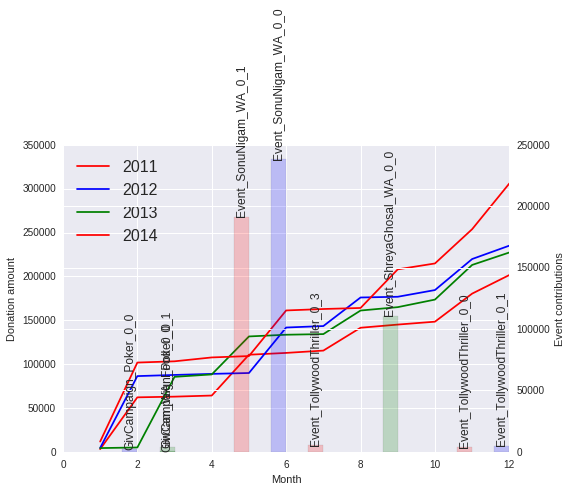

In [46]:
ymdata = plot_event_donation_activity('WA', [2011,2012,2013,2014])

In [45]:
ymdata

activity_month,1,2,3,4,5,6,7,8,9,10,11,12
activity_year,,,,,,,,,,,,
2002,0,0,0,345,345,395,1525,2099,2204,2654,4466,4906
2003,172,947,3793,6642,8666,13763,17159,19318,20415,20933,26623,29160
2004,2391,4849,5171,16033,16163,22657,23748,25728,29538,29769,36230,41028
2005,410,7018,22712,23192,24342,34862,35562,35828,42545,42800,50966,58061
2006,625,1781,24479,26304,59615,60186,63264,77780,78770,79903,104406,130779
2007,90,32781,38651,86072,88996,124906,127183,153767,155300,156494,183346,212725
2008,795,75761,78966,79666,106553,108924,114661,137333,139215,142147,170531,185464
2009,1438,5030,26466,74113,103920,105551,107265,132895,139265,152821,182373,193653
2010,1581,43753,45319,47316,118675,119266,128417,156841,159137,160898,221471,244540


In [30]:
ymdata.ffill(axis=1)[:-1].index.values
ymdata.ffill(axis=1)[-1:].values[0]

array([  11679.,  101782.,  103200.,  107616.,  109185.,  161203.,
        162852.,  164025.,  208078.,  214800.,  253892.,  306037.])

In [31]:
cumulative_years = np.cumsum(
    donations[(donations.activity_year > 2010)]\
        .groupby(['activity_year', 'activity_month'])['amount', ]\
        .sum()\
        .unstack()\
        .fillna(0)
    , axis=1, dtype='int64').T

In [32]:
cumulative_years

activity_year             2011     2012     2013     2014
       activity_month                                    
amount 1                225768   241758   167878   163458
       2                466666   516999   396281   491360
       3                625877   693788   656565   676989
       4                752315   830742   833577   841512
       5                957861   938960  1132831   968657
       6               1051251  1105716  1241186  1301598
       7               1225031  1212630  1326673  1436384
       8               1354450  1361091  1477652  1560007
       9               1481098  1512333  1606177  1809155
       10              1609885  1653297  1731978  2042312
       11              1811754  1895234  1976294  2503234
       12              2594611  2910405  2922536  3989516

In [33]:
ymdata

activity_month,1,2,3,4,5,6,7,8,9,10,11,12
activity_year,,,,,,,,,,,,
2002,0,0,0,345,345,395,1525,2099,2204,2654,4466,4906
2003,172,947,3793,6642,8666,13763,17159,19318,20415,20933,26623,29160
2004,2391,4849,5171,16033,16163,22657,23748,25728,29538,29769,36230,41028
2005,410,7018,22712,23192,24342,34862,35562,35828,42545,42800,50966,58061
2006,625,1781,24479,26304,59615,60186,63264,77780,78770,79903,104406,130779
2007,90,32781,38651,86072,88996,124906,127183,153767,155300,156494,183346,212725
2008,795,75761,78966,79666,106553,108924,114661,137333,139215,142147,170531,185464
2009,1438,5030,26466,74113,103920,105551,107265,132895,139265,152821,182373,193653
2010,1581,43753,45319,47316,118675,119266,128417,156841,159137,160898,221471,244540
